# Generalized Entaglement Purification Protocol functions 

### Helper Functions (tomography, density matrix extractor)

In [103]:
import itertools
import numpy as np
import stim
from typing import Sequence
import stim
from qutip import Qobj, ptrace
import matplotlib.pyplot as plt

def sample(circuit, shots, indices, inclusive=True):
    """
    Returns a dense int array of shape (shots, total_cols).
    'indices' can mix single ints and [start, end] ranges (inclusive).
    """
    # Normalize indices to a list
    if isinstance(indices, (int, np.integer)):
        indices = [int(indices)]

    sampler = circuit.compile_sampler()
    rows = []
    row_len = None

    for _ in range(shots):
        m = sampler.sample(1)[0]  # 1D array of measurement bits for this shot
        parts = []
        for idx in indices:
            if isinstance(idx, (list, tuple)) and len(idx) == 2:
                s, e = idx
                if inclusive:
                    e = e + 1
                parts.append(m[s:e])
            else:
                i = int(idx)
                parts.append(m[i:i+1])
        row = np.concatenate(parts, axis=0).astype(int, copy=False)

        if row_len is None:
            row_len = len(row)
        elif len(row) != row_len:
            raise ValueError(
                f"Inconsistent columns across shots: expected {row_len}, got {len(row)}. "
                "Ensure your 'indices' produce the same total length each shot."
            )
        rows.append(row)

    return np.vstack(rows)

def plot_syndromes(measurements, rows_to_plot, figsize=None):
    """
    Plot error counts for selected rows.
    rows_to_plot: e.g. [0], [0,1], [2,3] where r maps to S{r//2+1}-N{r%2+1}.
    Input 'measurements' is (shots, cols) int array:
      - FULL: >=24 cols as 8 triplets in order
        [S1N1 bit, S1N1 phase, S1N2 bit, S1N2 phase, S2N1 bit, S2N1 phase, S2N2 bit, S2N2 phase]
      - PRE-SLICED: exactly 6*len(rows_to_plot) cols: [row0 bit(3), row0 phase(3), row1 bit(3), row1 phase(3), ...]
    """
    rows_to_plot = list(rows_to_plot)
    if not rows_to_plot:
        raise ValueError("rows_to_plot must not be empty.")
    m = np.asarray(measurements, dtype=int)
    shots, cols = m.shape
    k = len(rows_to_plot)
    if cols % 3:
        raise ValueError("Columns must be a multiple of 3 (triplets).")

    # Build (shots, 2*k, 3) of [bit, phase] triplets per requested row
    if cols >= 24:
        t_idx = sum(([2*r, 2*r+1] for r in rows_to_plot), [])
        triplets = [m[:, 3*g:3*(g+1)] for g in t_idx]
        synds = np.concatenate(triplets, axis=1).reshape(shots, 2*k, 3)
    elif cols == 6*k:
        synds = m.reshape(shots, 2*k, 3)
    else:
        raise ValueError("Provide either full (>=24) or pre-sliced (==6*len(rows_to_plot)) columns.")

    def label(r): return f"S{r//2+1}-N{r%2+1}"
    titles = [f"{label(r)} {t}" for r in rows_to_plot for t in ("bit", "phase")]
    weights = np.array([1, 2, 4])

    if figsize is None:
        figsize = (8, 3*k)
    fig, axes = plt.subplots(k, 2, figsize=figsize, sharey=True)
    axes = np.atleast_2d(axes)

    for i in range(k):
        for side in (0, 1):
            ax = axes[i, side]
            codes = synds[:, 2*i + side, :] @ weights          # 0..7
            errors = codes[codes > 0] - 1                       # 1..7 -> 0..6
            counts = np.bincount(errors, minlength=7)
            x = np.arange(7)
            ax.bar(x, counts, width=0.6)
            ax.set_xticks(x)
            ax.set_xticklabels([f"$q_{{{j}}}$" for j in x])
            ax.set_ylim(0, shots)
            ax.set_title(titles[2*i + side])
            ax.set_ylabel("Error Count")
            ax.grid(True, linestyle=":", alpha=0.5)

    fig.suptitle(", ".join(map(label, rows_to_plot)), y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

def tomography(circuit: stim.Circuit,
    qubits: tuple[int, int], shots: int = 10000
) -> np.ndarray:
    """
    Reconstruct the reduced density matrix on the specified pair of qubits
    after entanglement swapping by performing Pauli tomography.

    Args:
        qubits: Tuple of two qubit indices (e.g., (0, 3)).
        shots: Number of samples per Pauli setting.

    Returns:
        rho: 4×4 numpy array representing the density matrix on those qubits.
    """
    q0, q1 = qubits
    base = circuit.copy()
    paulis = ['I', 'X', 'Y', 'Z']
    exp_vals: dict[tuple[str, str], float] = {}

    # Estimate expectation for each Pauli pair
    for p0 in paulis:
        for p1 in paulis:
            if p0 == 'I' and p1 == 'I':
                exp_vals[(p0, p1)] = 1.0
                continue

            c = base.copy()
            tom_count = 0

            # Rotate & measure on q0 if needed
            if p0 != 'I':
                if p0 == 'X':
                    c.append("H", [q0])
                elif p0 == 'Y':
                    c.append("S_DAG", [q0])
                    c.append("H", [q0])
                c.append("M", [q0])
                tom_count += 1

            # Rotate & measure on q1 if needed
            if p1 != 'I':
                if p1 == 'X':
                    c.append("H", [q1])
                elif p1 == 'Y':
                    c.append("S_DAG", [q1])
                    c.append("H", [q1])
                c.append("M", [q1])
                tom_count += 1

            # Sample the circuit
            sampler = c.compile_sampler()
            bits = sampler.sample(shots)  # shape (shots, 2 + tom_count)

            # Extract tomography bits (always start at index 2)
            if tom_count == 2:
                m0 = bits[:, 2]
                m1 = bits[:, 3]
                exp_vals[(p0, p1)] = np.mean((1 - 2*m0) * (1 - 2*m1))
            elif p0 != 'I':
                m0 = bits[:, 2]
                exp_vals[(p0, p1)] = np.mean(1 - 2*m0)
            else:
                m1 = bits[:, 2]
                exp_vals[(p0, p1)] = np.mean(1 - 2*m1)

    # Reconstruct density matrix via Pauli expansion
    sigma = {
        'I': np.eye(2, dtype=complex),
        'X': np.array([[0, 1], [1, 0]], dtype=complex),
        'Y': np.array([[0, -1j], [1j, 0]], dtype=complex),
        'Z': np.array([[1, 0], [0, -1]], dtype=complex),
    }
    rho = sum(
        exp_vals[(p0, p1)] * np.kron(sigma[p0], sigma[p1])
        for p0 in paulis for p1 in paulis
    ) / 4

    return rho

def tomography_on_circuit(circuit: stim.Circuit, qubits: tuple[int, int], shots: int = 10000):
    """
    Perform 2-qubit Pauli tomography on the specified pair of qubits in the given circuit.
    Returns the reconstructed 4x4 density matrix.
    
    Args:
        circuit: A stim.Circuit without demolition measurements.
        qubits: A tuple (q0, q1) of qubit indices to reconstruct.
        shots: Number of samples per Pauli setting.
    """
    paulis = ['I', 'X', 'Y', 'Z']
    exp_vals = {}

    # For each Pauli basis combination
    for p0 in paulis:
        for p1 in paulis:
            # The identity-identity expectation is always 1
            if p0 == 'I' and p1 == 'I':
                exp_vals[(p0, p1)] = 1.0
                continue

            # Copy the base circuit
            c = circuit.copy()
            meas_qubits = []

            # Apply basis change and measurement for first qubit
            if p0 != 'I':
                if p0 == 'X':
                    c.append('H', [qubits[0]])
                elif p0 == 'Y':
                    c.append('S_DAG', [qubits[0]])
                    c.append('H', [qubits[0]])
                c.append('M', [qubits[0]])
                meas_qubits.append(qubits[0])

            # Apply basis change and measurement for second qubit
            if p1 != 'I':
                if p1 == 'X':
                    c.append('H', [qubits[1]])
                elif p1 == 'Y':
                    c.append('S_DAG', [qubits[1]])
                    c.append('H', [qubits[1]])
                c.append('M', [qubits[1]])
                meas_qubits.append(qubits[1])

            # Sample the circuit
            sampler = c.compile_sampler()
            bits = sampler.sample(shots)  # shape (shots, len(meas_qubits))

            # Compute expectation value
            if len(meas_qubits) == 2:
                m0 = bits[:, 0]
                m1 = bits[:, 1]
                exp_vals[(p0, p1)] = np.mean((1 - 2*m0) * (1 - 2*m1))
            else:
                m = bits[:, 0]
                exp_vals[(p0, p1)] = np.mean(1 - 2*m)

    # Reconstruct density matrix from Pauli expectations
    sigma = {
        'I': np.eye(2, dtype=complex),
        'X': np.array([[0,1],[1,0]], dtype=complex),
        'Y': np.array([[0,-1j],[1j,0]], dtype=complex),
        'Z': np.array([[1,0],[0,-1]], dtype=complex),
    }
    rho = sum(
        exp_vals[(p0, p1)] * np.kron(sigma[p0], sigma[p1])
        for p0 in paulis for p1 in paulis
    ) / 4

    return rho

def tomography_dm(
    circuit: stim.Circuit,
    qubits: list[int] | tuple[int, ...],
    shots: int = 10_000,
    use_direct_pauli_meas: bool = True,
) -> np.ndarray:
    """
    Reconstruct the reduced density matrix on `qubits` of a Stim circuit using
    full Pauli tomography and linear inversion.

    ρ = (1 / 2^k) * Σ_{P∈{I,X,Y,Z}^k} ⟨P⟩ P

    Args:
        circuit: The base stim.Circuit (may contain any gates/measurements).
        qubits:  Iterable of qubit indices to reconstruct (length = k).
        shots:   Number of samples per Pauli setting.
        use_direct_pauli_meas:
                 True  -> use MX/MY/M (Z) instructions (cleaner, recommended).
                 False -> rotate with H/S_DAG then use M (Z) for all Pauli bases.

    Returns:
        rho: A (2**k × 2**k) complex numpy array (density matrix on `qubits`).
    """
    # ---- Pauli helpers ----
    PAULIS = ("I", "X", "Y", "Z")
    SIGMA = {
        "I": np.eye(2, dtype=complex),
        "X": np.array([[0, 1], [1, 0]], dtype=complex),
        "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),
        "Z": np.array([[1, 0], [0, -1]], dtype=complex),
    }

    def kron_all(mats):
        out = mats[0]
        for m in mats[1:]:
            out = np.kron(out, m)
        return out

    qubits = tuple(qubits)
    k = len(qubits)
    base_meas = circuit.num_measurements  # how many M/MX/MY/MZ are already there
    exp_vals = {}

    # Iterate over every Pauli string on these k qubits
    for setting in itertools.product(PAULIS, repeat=k):
        # identity on all => expectation is 1
        if all(p == "I" for p in setting):
            exp_vals[setting] = 1.0
            continue

        # Clone base circuit and append tomography operations
        c = circuit.copy()
        measured_count = 0

        if use_direct_pauli_meas:
            # Direct Pauli demolition measurements
            for q, p in zip(qubits, setting):
                if p == "I":
                    continue
                gate = {"X": "MX", "Y": "MY", "Z": "M"}[p]
                c.append(gate, [q])
                measured_count += 1
        else:
            # Basis-rotate then M (Z)
            for q, p in zip(qubits, setting):
                if p == "I":
                    continue
                if p == "X":
                    c.append("H", [q])
                elif p == "Y":
                    c.append("S_DAG", [q])
                    c.append("H", [q])
                # Z: do nothing
                c.append("M", [q])
                measured_count += 1

        # Sample
        sampler = c.compile_sampler()
        bits = sampler.sample(shots=shots)

        # Extract the tomography bits we just added (they appear at the end)
        tomo_bits = bits[:, base_meas: base_meas + measured_count]
        eig = 1 - 2 * tomo_bits  # 0->+1, 1->-1

        # Expectation is product of eigenvalues across all measured qubits
        exp_vals[setting] = float(np.mean(np.prod(eig, axis=1))) if measured_count > 1 else float(np.mean(eig))

    # Linear inversion reconstruction
    dim = 2 ** k
    rho = np.zeros((dim, dim), dtype=complex)
    for setting, val in exp_vals.items():
        mats = [SIGMA[p] for p in setting]
        rho += val * kron_all(mats)
    rho /= dim

    return rho

def get_exact_density_matrix(
    circuit: stim.Circuit,
    keep_qubits: Sequence[int]
) -> np.ndarray:
    """
    Given a Clifford circuit and a list of qubits to keep, return
    the exact reduced density matrix on those qubits.

    Args:
        circuit: a stim.Circuit acting on N qubits.
        keep_qubits: sorted list of distinct qubit indices in [0, N).
    Returns:
        (2^k × 2^k) NumPy array for k = len(keep_qubits).
    """
    # --- 1) Validate inputs ---
    n = circuit.num_qubits
    if not keep_qubits:
        raise ValueError("keep_qubits must be non‑empty")
    if any((q < 0 or q >= n) for q in keep_qubits):
        raise IndexError(f"keep_qubits entries must be in [0, {n-1}]")
    if len(set(keep_qubits)) != len(keep_qubits):
        raise ValueError("keep_qubits contains duplicates")

    # --- 2) Run the circuit in the tableau simulator ---
    sim = stim.TableauSimulator()
    sim.do(circuit)

    # --- 3) Extract the statevector ---
    try:
        # Stim ≥1.9: direct access to the 2^n amplitudes
        psi = np.array(sim.state_vector(), dtype=complex)
    except AttributeError:
        # Fallback: build the sparse unitary via the same tableau
        U = circuit.to_sparse_unitary().toarray()
        psi0 = np.zeros((2**n,), dtype=complex)
        psi0[0] = 1.0
        psi = U.dot(psi0)

    # --- 4) Form the full density matrix ρ = |ψ><ψ| ---
    rho_full = np.outer(psi, psi.conj())

    # --- 5) Partial trace via QuTiP ---
    dims = [[2]*n, [2]*n]
    qobj = Qobj(rho_full, dims=dims)
    rho_reduced = ptrace(qobj, list(keep_qubits))

    return np.array(rho_reduced.full())


### Generalized [[7,1,3]] encoding (Physical -> Logical)

In [3]:
import stim

def encode_713(circuit: stim.Circuit, qubit_indices: list[int]) -> stim.Circuit:
    c = circuit.copy()
    q = qubit_indices
    c.append("H", [q[4], q[5], q[6]])

    c.append("CX", [q[0], q[1]])
    c.append("CX", [q[0], q[2]])

    c.append("CX", [q[6], q[3]])
    c.append("CX", [q[6], q[1]])
    c.append("CX", [q[6], q[0]])

    c.append("CX", [q[5], q[3]])
    c.append("CX", [q[5], q[2]])
    c.append("CX", [q[5], q[0]])

    c.append("CX", [q[4], q[3]])
    c.append("CX", [q[4], q[2]])
    c.append("CX", [q[4], q[1]])
    
    return c

def decode_713(circuit: stim.Circuit, qubit_indices: list[int]) -> stim.Circuit:
    c = circuit.copy()
    q = qubit_indices

    c.append("CX", [q[4], q[1]])
    c.append("CX", [q[4], q[2]])
    c.append("CX", [q[4], q[3]])

    c.append("CX", [q[5], q[0]])
    c.append("CX", [q[5], q[2]])
    c.append("CX", [q[5], q[3]])

    c.append("CX", [q[6], q[0]])
    c.append("CX", [q[6], q[1]])
    c.append("CX", [q[6], q[3]])

    c.append("CX", [q[0], q[2]])
    c.append("CX", [q[0], q[1]])

    c.append("H", [q[4], q[5], q[6]])

    return c

### Generalized [[7,1,3]] Stabalizers 

In [4]:
import stim

def stabalizers_713(circuit: stim.Circuit, data_qubit_indices: list[int], ancilla_qubit_indicies: list[int]) -> stim.Circuit:
    c = circuit.copy()
    d = data_qubit_indices
    a = ancilla_qubit_indicies

    # --- Stabilizer Measurements ------------------------------------------
    # Bit-flip syndrome
    c.append("CX", [d[0], a[0]])
    c.append("CX", [d[2], a[0]])
    c.append("CX", [d[4], a[0]])
    c.append("CX", [d[6], a[0]])

    c.append("CX", [d[1], a[1]])
    c.append("CX", [d[2], a[1]])
    c.append("CX", [d[5], a[1]])
    c.append("CX", [d[6], a[1]])

    c.append("CX", [d[3], a[2]])
    c.append("CX", [d[4], a[2]])
    c.append("CX", [d[5], a[2]])
    c.append("CX", [d[6], a[2]])

    # Phase-flip syndrome
    c.append("H", [a[3], a[4], a[5]])
 
    c.append("CX", [a[3], d[0]])
    c.append("CX", [a[3], d[2]])
    c.append("CX", [a[3], d[4]])
    c.append("CX", [a[3], d[6]])

    c.append("CX", [a[4], d[1]])
    c.append("CX", [a[4], d[2]])
    c.append("CX", [a[4], d[5]])
    c.append("CX", [a[4], d[6]])

    c.append("CX", [a[5], d[3]])
    c.append("CX", [a[5], d[4]])
    c.append("CX", [a[5], d[5]])
    c.append("CX", [a[5], d[6]])

    c.append("H", [a[3], a[4], a[5]])

    # Bit measurements
    c.append("M", [a[0]])   
    # c.append("DETECTOR", [stim.target_rec(-1)])
    c.append("M", [a[1]])   
    # c.append("DETECTOR", [stim.target_rec(-1)])
    c.append("M", [a[2]])   
    # c.append("DETECTOR", [stim.target_rec(-1)])

    # Phase Measurements
    c.append("M", [a[3]])   
    # c.append("DETECTOR", [stim.target_rec(-1)])
    c.append("M", [a[4]])   
    # c.append("DETECTOR", [stim.target_rec(-1)])
    c.append("M", [a[5]])   
    # c.append("DETECTOR", [stim.target_rec(-1)])
    
    return c

### Generalized T-CNOT Stim (Sampling)

In [5]:
import stim

def tcnot(circuit: stim.Circuit, qubit_dict: dict) -> stim.Circuit:
    """
    Applies a T-CNOT operation on the specified qubits in the given circuit.

    Args:
        circuit: A stim.Circuit object representing the quantum circuit.
        qubit_dict: A dictionary containing lists of qubit indices:
            - 'n1_memory': List of memory qubit indices for the first block.
            - 'n1_ancilla': List of ancilla qubit indices for the first block.
            - 'n2_ancilla': List of ancilla qubit indices for the second block.
            - 'n2_memory': List of memory qubit indices for the second block.
            Example:
                {
                    'n1_memory': [0, 1, 2],
                    'n1_ancilla': [3, 4, 5],
                    'n2_ancilla': [6, 7, 8],
                    'n2_memory': [9, 10, 11]
                }

    Returns:
        c: A stim.Circuit object representing the modified circuit after applying T-CNOT operations.
    """
    c = circuit.copy()

    n1_memory = qubit_dict['n1_memory']
    n1_ancilla = qubit_dict['n1_communcation']
    n2_ancilla = qubit_dict['n2_communcation']
    n2_memory = qubit_dict['n2_memory']
    
    block_length = len(n1_memory)  # Assuming all lists are of the same length

    for _ in range(block_length):
        c.append('H', n1_memory[_])  
        c.append("H", n1_ancilla[_])
        c.append("CNOT", [n1_ancilla[_], n2_ancilla[_]])
        c.append('CNOT', [n1_memory[_], n1_ancilla[_]])
        c.append('CNOT', [n2_ancilla[_], n2_memory[_]])
        c.append('M', [n1_ancilla[_]])
        c.append('CX', [stim.target_rec(-1), stim.GateTarget(n2_memory[_])])
        c.append("H", [n2_ancilla[_]])
        c.append('M', [n2_ancilla[_]])
        c.append('CZ', [stim.target_rec(-1), stim.GateTarget(n1_memory[_])])
    
    return c



### Generalized Entanglement Swapping Stim (Sampling)

In [6]:
import stim 

def entanglment_swapping(circuit: stim.Circuit, qubit_indices: list[int], total_qubits: int, bell_state_prepared = True) -> stim.Circuit:
    """
    Constructs the entanglement swapping circuit on specified qubits:
    - Prepare Bell pairs on the specified qubit indices.
    - Bell measurement on the middle qubits.
    - Pauli-frame corrections on the last qubit.

    Args:
        qubit_indices: List of qubit indices to perform entanglement swapping on.
        total_qubits: Total number of qubits in the system.

    Returns:
        c: stim.Circuit representing the entanglement swapping circuit.
    """
    c = circuit.copy()
    
    if not bell_state_prepared:
        # Prepare Bell pairs
        for i in range(0, len(qubit_indices), 2):
            c.append("H", [qubit_indices[i]])
            c.append("CNOT", [qubit_indices[i], qubit_indices[i + 1]])

    # Bell measurement on the middle qubits
    c.append("CNOT", [qubit_indices[1], qubit_indices[2]])
    c.append("H", [qubit_indices[1]])
    c.append("M", [qubit_indices[1]])  # m_X
    c.append("M", [qubit_indices[2]])  # m_Z

    # Pauli-frame corrections on the last qubit
    c.append('CX', [stim.target_rec(-1), stim.GateTarget(qubit_indices[3])])
    c.append('CZ', [stim.target_rec(-2), stim.GateTarget(qubit_indices[3])])


    return c

# Entanglement Purification Protocol

In [101]:
import stim
import random

def entaglement_purification_qec():
    
    circuit = stim.Circuit()
    total_qubits = 80
    block_length = 7
    station1 = {
                'n1_memory': [0, 1, 2, 3, 4, 5, 6],
                'n1_communcation': [7, 8, 9, 10, 11, 12, 13],
                'n2_communcation': [14, 15, 16, 17, 18, 19, 20],
                'n2_memory': [21, 22, 23, 24, 25, 26, 27],
                'n1_ancilla' : [56, 57, 58, 59, 60, 61],
                'n2_ancilla' : [62, 63, 64, 65, 66, 67]
                }
    station2 = {
                'n1_memory' : [28, 29, 30, 31, 32, 33, 34],
                'n1_communcation' : [35, 36, 37, 38, 39, 40, 41],
                'n2_communcation' : [42, 43, 44, 45, 46, 47, 48],
                'n2_memory' : [49, 50, 51, 52, 53, 54, 55],
                'n1_ancilla' : [68, 69, 70, 71, 72, 73],
                'n2_ancilla' : [74, 75, 76, 77, 78, 79]
                }
    
    
    def stabalizers(circuit, nodes: list = None):
        c = circuit.copy()
        if 0 in nodes:
            c = stabalizers_713(c, station1['n1_memory'], station1['n1_ancilla'])
        if 1 in nodes:
            c = stabalizers_713(c, station1['n2_memory'], station1['n2_ancilla'])
        if 2 in nodes:
            c = stabalizers_713(c, station2['n1_memory'], station2['n1_ancilla'])   
        if 3 in nodes:
            c = stabalizers_713(c, station2['n2_memory'], station2['n2_ancilla'])       
        return c  

    circuit.append("I", [i for i in range(80)])
    circuit = encode_713(circuit, station1['n1_memory'])
    circuit = encode_713(circuit, station1['n2_memory']) 
    circuit = encode_713(circuit, station2['n1_memory']) 
    circuit = encode_713(circuit, station2['n2_memory']) 

    p = random.random()
    if p <= 0.1:
        circuit.append('X', [0])
        circuit = stabalizers(circuit, [0])
        circuit.append('X', [0])


    circuit = tcnot(circuit, station1)

    circuit = tcnot(circuit, station2)

    for i in range(block_length):
        qubit_indicies = [station1['n1_memory'][i], station1['n2_memory'][i], station2['n1_memory'][i], station2['n2_memory'][i]]
        circuit = entanglment_swapping(circuit = circuit, qubit_indices = qubit_indicies, total_qubits = total_qubits)
    
    circuit = decode_713(circuit, station1['n1_memory'])
    # circuit = decode_713(circuit, station1['n2_memory']) 
    # circuit = decode_713(circuit, station2['n1_memory']) 
    circuit = decode_713(circuit, station2['n2_memory']) 

    return circuit


In [104]:
events = sample(entaglement_purification_qec(), shots = 100, indices = [[0,2], [3,5], [21,23], [24,26]])
plot_syndromes(events, [0])

ValueError: Provide either full (>=24) or pre-sliced (==6*len(rows_to_plot)) columns.

############

### Fidelity Calculation

In [88]:
import numpy as np

circuit = entaglement_purification_qec()
sampler = circuit.compile_sampler()
events = sampler.sample(shots=10000) 
rho = tomography_dm(circuit, [0,49])
print(rho)

def fidelity_phi_plus(rho: np.ndarray) -> float:
    """
    Compute the fidelity F = ⟨Φ⁺| rho |Φ⁺⟩ of a two-qubit state ρ
    with the Bell state |Φ+> = (|00> + |11>)/√2.

    Args:
        rho: a 4x4 complex numpy array representing the density matrix.

    Returns:
        Fidelity F ∈ [0,1].
    """
    # check shape
    if rho.shape != (4, 4):
        raise ValueError(f"Expected a 4x4 density matrix, got shape {rho.shape}")

    # define |Φ+> = (|00> + |11>)/√2
    phi_plus = np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2)

    # F = ⟨Φ+| rho |Φ+>
    F = np.vdot(phi_plus, rho @ phi_plus)  
    return float(np.real(F))

print(fidelity_phi_plus(rho)) 


[[ 4.988e-01+0.j      -1.000e-04-0.00345j -7.150e-03-0.00345j
   5.000e-01+0.0028j ]
 [-1.000e-04+0.00345j  3.300e-03+0.j       0.000e+00-0.001j
   5.950e-03+0.00655j]
 [-7.150e-03+0.00345j  0.000e+00+0.001j   -3.300e-03+0.j
  -7.400e-03+0.00025j]
 [ 5.000e-01-0.0028j   5.950e-03-0.00655j -7.400e-03-0.00025j
   5.012e-01+0.j     ]]
0.9999999999999998


# Results

### Result Analyzing Functions (Tomography, Density Matrix Extractor)

In [197]:
import itertools
import numpy as np
import stim
from typing import Sequence
import stim
from qutip import Qobj, ptrace

def tomography(circuit: stim.Circuit,
    qubits: tuple[int, int], shots: int = 10000
) -> np.ndarray:
    """
    Reconstruct the reduced density matrix on the specified pair of qubits
    after entanglement swapping by performing Pauli tomography.

    Args:
        qubits: Tuple of two qubit indices (e.g., (0, 3)).
        shots: Number of samples per Pauli setting.

    Returns:
        rho: 4×4 numpy array representing the density matrix on those qubits.
    """
    q0, q1 = qubits
    base = circuit.copy()
    paulis = ['I', 'X', 'Y', 'Z']
    exp_vals: dict[tuple[str, str], float] = {}

    # Estimate expectation for each Pauli pair
    for p0 in paulis:
        for p1 in paulis:
            if p0 == 'I' and p1 == 'I':
                exp_vals[(p0, p1)] = 1.0
                continue

            c = base.copy()
            tom_count = 0

            # Rotate & measure on q0 if needed
            if p0 != 'I':
                if p0 == 'X':
                    c.append("H", [q0])
                elif p0 == 'Y':
                    c.append("S_DAG", [q0])
                    c.append("H", [q0])
                c.append("M", [q0])
                tom_count += 1

            # Rotate & measure on q1 if needed
            if p1 != 'I':
                if p1 == 'X':
                    c.append("H", [q1])
                elif p1 == 'Y':
                    c.append("S_DAG", [q1])
                    c.append("H", [q1])
                c.append("M", [q1])
                tom_count += 1

            # Sample the circuit
            sampler = c.compile_sampler()
            bits = sampler.sample(shots)  # shape (shots, 2 + tom_count)

            # Extract tomography bits (always start at index 2)
            if tom_count == 2:
                m0 = bits[:, 2]
                m1 = bits[:, 3]
                exp_vals[(p0, p1)] = np.mean((1 - 2*m0) * (1 - 2*m1))
            elif p0 != 'I':
                m0 = bits[:, 2]
                exp_vals[(p0, p1)] = np.mean(1 - 2*m0)
            else:
                m1 = bits[:, 2]
                exp_vals[(p0, p1)] = np.mean(1 - 2*m1)

    # Reconstruct density matrix via Pauli expansion
    sigma = {
        'I': np.eye(2, dtype=complex),
        'X': np.array([[0, 1], [1, 0]], dtype=complex),
        'Y': np.array([[0, -1j], [1j, 0]], dtype=complex),
        'Z': np.array([[1, 0], [0, -1]], dtype=complex),
    }
    rho = sum(
        exp_vals[(p0, p1)] * np.kron(sigma[p0], sigma[p1])
        for p0 in paulis for p1 in paulis
    ) / 4

    return rho

def tomography_on_circuit(circuit: stim.Circuit, qubits: tuple[int, int], shots: int = 10000):
    """
    Perform 2-qubit Pauli tomography on the specified pair of qubits in the given circuit.
    Returns the reconstructed 4x4 density matrix.
    
    Args:
        circuit: A stim.Circuit without demolition measurements.
        qubits: A tuple (q0, q1) of qubit indices to reconstruct.
        shots: Number of samples per Pauli setting.
    """
    paulis = ['I', 'X', 'Y', 'Z']
    exp_vals = {}

    # For each Pauli basis combination
    for p0 in paulis:
        for p1 in paulis:
            # The identity-identity expectation is always 1
            if p0 == 'I' and p1 == 'I':
                exp_vals[(p0, p1)] = 1.0
                continue

            # Copy the base circuit
            c = circuit.copy()
            meas_qubits = []

            # Apply basis change and measurement for first qubit
            if p0 != 'I':
                if p0 == 'X':
                    c.append('H', [qubits[0]])
                elif p0 == 'Y':
                    c.append('S_DAG', [qubits[0]])
                    c.append('H', [qubits[0]])
                c.append('M', [qubits[0]])
                meas_qubits.append(qubits[0])

            # Apply basis change and measurement for second qubit
            if p1 != 'I':
                if p1 == 'X':
                    c.append('H', [qubits[1]])
                elif p1 == 'Y':
                    c.append('S_DAG', [qubits[1]])
                    c.append('H', [qubits[1]])
                c.append('M', [qubits[1]])
                meas_qubits.append(qubits[1])

            # Sample the circuit
            sampler = c.compile_sampler()
            bits = sampler.sample(shots)  # shape (shots, len(meas_qubits))

            # Compute expectation value
            if len(meas_qubits) == 2:
                m0 = bits[:, 0]
                m1 = bits[:, 1]
                exp_vals[(p0, p1)] = np.mean((1 - 2*m0) * (1 - 2*m1))
            else:
                m = bits[:, 0]
                exp_vals[(p0, p1)] = np.mean(1 - 2*m)

    # Reconstruct density matrix from Pauli expectations
    sigma = {
        'I': np.eye(2, dtype=complex),
        'X': np.array([[0,1],[1,0]], dtype=complex),
        'Y': np.array([[0,-1j],[1j,0]], dtype=complex),
        'Z': np.array([[1,0],[0,-1]], dtype=complex),
    }
    rho = sum(
        exp_vals[(p0, p1)] * np.kron(sigma[p0], sigma[p1])
        for p0 in paulis for p1 in paulis
    ) / 4

    return rho

def tomography_dm(
    circuit: stim.Circuit,
    qubits: list[int] | tuple[int, ...],
    shots: int = 10_000,
    use_direct_pauli_meas: bool = True,
) -> np.ndarray:
    """
    Reconstruct the reduced density matrix on `qubits` of a Stim circuit using
    full Pauli tomography and linear inversion.

    ρ = (1 / 2^k) * Σ_{P∈{I,X,Y,Z}^k} ⟨P⟩ P

    Args:
        circuit: The base stim.Circuit (may contain any gates/measurements).
        qubits:  Iterable of qubit indices to reconstruct (length = k).
        shots:   Number of samples per Pauli setting.
        use_direct_pauli_meas:
                 True  -> use MX/MY/M (Z) instructions (cleaner, recommended).
                 False -> rotate with H/S_DAG then use M (Z) for all Pauli bases.

    Returns:
        rho: A (2**k × 2**k) complex numpy array (density matrix on `qubits`).
    """
    # ---- Pauli helpers ----
    PAULIS = ("I", "X", "Y", "Z")
    SIGMA = {
        "I": np.eye(2, dtype=complex),
        "X": np.array([[0, 1], [1, 0]], dtype=complex),
        "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),
        "Z": np.array([[1, 0], [0, -1]], dtype=complex),
    }

    def kron_all(mats):
        out = mats[0]
        for m in mats[1:]:
            out = np.kron(out, m)
        return out

    qubits = tuple(qubits)
    k = len(qubits)
    base_meas = circuit.num_measurements  # how many M/MX/MY/MZ are already there
    exp_vals = {}

    # Iterate over every Pauli string on these k qubits
    for setting in itertools.product(PAULIS, repeat=k):
        # identity on all => expectation is 1
        if all(p == "I" for p in setting):
            exp_vals[setting] = 1.0
            continue

        # Clone base circuit and append tomography operations
        c = circuit.copy()
        measured_count = 0

        if use_direct_pauli_meas:
            # Direct Pauli demolition measurements
            for q, p in zip(qubits, setting):
                if p == "I":
                    continue
                gate = {"X": "MX", "Y": "MY", "Z": "M"}[p]
                c.append(gate, [q])
                measured_count += 1
        else:
            # Basis-rotate then M (Z)
            for q, p in zip(qubits, setting):
                if p == "I":
                    continue
                if p == "X":
                    c.append("H", [q])
                elif p == "Y":
                    c.append("S_DAG", [q])
                    c.append("H", [q])
                # Z: do nothing
                c.append("M", [q])
                measured_count += 1

        # Sample
        sampler = c.compile_sampler()
        bits = sampler.sample(shots=shots)

        # Extract the tomography bits we just added (they appear at the end)
        tomo_bits = bits[:, base_meas: base_meas + measured_count]
        eig = 1 - 2 * tomo_bits  # 0->+1, 1->-1

        # Expectation is product of eigenvalues across all measured qubits
        exp_vals[setting] = float(np.mean(np.prod(eig, axis=1))) if measured_count > 1 else float(np.mean(eig))

    # Linear inversion reconstruction
    dim = 2 ** k
    rho = np.zeros((dim, dim), dtype=complex)
    for setting, val in exp_vals.items():
        mats = [SIGMA[p] for p in setting]
        rho += val * kron_all(mats)
    rho /= dim

    return rho

def get_exact_density_matrix(
    circuit: stim.Circuit,
    keep_qubits: Sequence[int]
) -> np.ndarray:
    """
    Given a Clifford circuit and a list of qubits to keep, return
    the exact reduced density matrix on those qubits.

    Args:
        circuit: a stim.Circuit acting on N qubits.
        keep_qubits: sorted list of distinct qubit indices in [0, N).
    Returns:
        (2^k × 2^k) NumPy array for k = len(keep_qubits).
    """
    # --- 1) Validate inputs ---
    n = circuit.num_qubits
    if not keep_qubits:
        raise ValueError("keep_qubits must be non‑empty")
    if any((q < 0 or q >= n) for q in keep_qubits):
        raise IndexError(f"keep_qubits entries must be in [0, {n-1}]")
    if len(set(keep_qubits)) != len(keep_qubits):
        raise ValueError("keep_qubits contains duplicates")

    # --- 2) Run the circuit in the tableau simulator ---
    sim = stim.TableauSimulator()
    sim.do(circuit)

    # --- 3) Extract the statevector ---
    try:
        # Stim ≥1.9: direct access to the 2^n amplitudes
        psi = np.array(sim.state_vector(), dtype=complex)
    except AttributeError:
        # Fallback: build the sparse unitary via the same tableau
        U = circuit.to_sparse_unitary().toarray()
        psi0 = np.zeros((2**n,), dtype=complex)
        psi0[0] = 1.0
        psi = U.dot(psi0)

    # --- 4) Form the full density matrix ρ = |ψ><ψ| ---
    rho_full = np.outer(psi, psi.conj())

    # --- 5) Partial trace via QuTiP ---
    dims = [[2]*n, [2]*n]
    qobj = Qobj(rho_full, dims=dims)
    rho_reduced = ptrace(qobj, list(keep_qubits))

    return np.array(rho_reduced.full())


# 3 qubit code

### 3 qubit repetition code using stabalizer formalism (1 node)

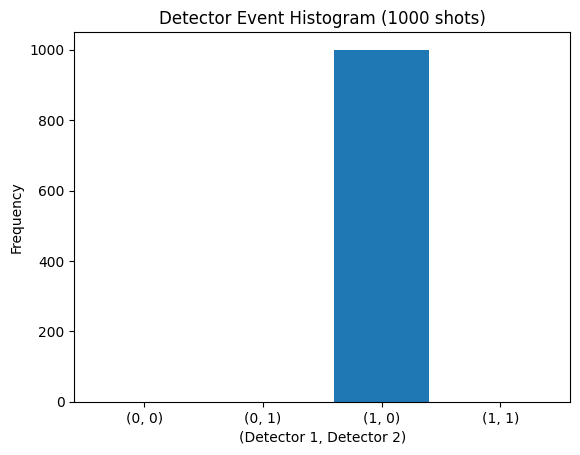

In [12]:
import stim
from collections import Counter
import matplotlib.pyplot as plt
import random

def three_qubit_repetition_code(p_error=0.1):
    circuit = stim.Circuit()

    circuit.append("I", 0)
    # circuit.append("CNOT", [0, 1])
    # circuit.append("CNOT", [0, 2])

    circuit.append("H", 0)
    circuit.append("CNOT", [0, 1])
    circuit.append("CNOT", [0, 2])

    circuit.append("X_ERROR", [0], [p_error])
    # 3) Measure Z0Z1 parity on ancilla 3
    circuit.append("CNOT", [0, 3])
    circuit.append("CNOT", [1, 3])
    circuit.append("M", 3)
    circuit.append("DETECTOR", [stim.target_rec(-1)])

    # 4) Measure Z1Z2 parity on ancilla 4
    circuit.append("CNOT", [1, 4])
    circuit.append("CNOT", [2, 4])
    circuit.append("M", 4)
    circuit.append("DETECTOR", [stim.target_rec(-1)])

    return circuit

# Build & sample
circuit = three_qubit_repetition_code(p_error=1)
# sampler = circuit.compile_sampler()
# shots = sampler.sample(shots=1000)   # e.g. 1000 shots

det_sampler = circuit.compile_detector_sampler()
det_events = det_sampler.sample(shots=1000)

# Count and plot the histogram
counts = Counter(tuple(s) for s in det_events)
outcomes = [(0, 0), (0, 1), (1, 0), (1, 1)]
plt.bar([str(o) for o in outcomes], [counts[o] for o in outcomes])
plt.xlabel("(Detector 1, Detector 2)")
plt.ylabel("Frequency")
plt.title("Detector Event Histogram (1000 shots)")
plt.show()

### Convert state vector to density matrix traced

In [307]:
import numpy as np

def reduced_rho_0_3(psi):
    """
    Given a 4‑qubit state vector psi (length 16),
    trace out qubits 1 and 2 to get the density matrix
    on qubits 0 and 3.
    """
    # Full density matrix 16×16
    rho_full = np.outer(psi, psi.conj())
    
    # Reshape to 8‑index tensor: (q0,q1,q2,q3, q0',q1',q2',q3')
    rho_t = rho_full.reshape([2,2,2,2, 2,2,2,2])
    
    # Allocate reduced tensor: (q0, q3, q0', q3')
    rho_red_t = np.zeros((2,2,2,2), dtype=complex)
    
    # Sum over q1=q1' and q2=q2'
    for i0 in range(2):
        for i3 in range(2):
            for j0 in range(2):
                for j3 in range(2):
                    s = 0+0j
                    for i1 in range(2):
                        for i2 in range(2):
                            s += rho_t[i0, i1, i2, i3, 
                                       j0, i1, i2, j3]
                    rho_red_t[i0, i3, j0, j3] = s
    
    # Collapse into a 4×4 matrix in basis [00,01,10,11]
    return rho_red_t.reshape(4,4)

# Your state vector:
psi = np.array([ 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0.707+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0.707+0j, 0+0j, 0+0j, 0+0j ]
, dtype=complex)

rho_0_3 = reduced_rho_0_3(psi)

# Display it
np.set_printoptions(precision=3, suppress=True)
print("Reduced density matrix on qubits 0 & 3:")
print(rho_0_3)


Reduced density matrix on qubits 0 & 3:
[[0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]]


### Qutip entaglment swapping

In [134]:
from qutip import tensor, basis, ket2dm, Qobj, ptrace
import numpy as np

def entanglement_swapping_qutip():
    """
    Simulate entanglement swapping on 4 qubits (0–3):
    • Prepare |Φ+> on (0,1) and (2,3).
    • Bell-measure qubits 1 & 2.
    • Apply the corresponding Pauli on qubit 3.
    • Return the reduced density matrix on qubits (0,3).
    """
    # 1) Define the four Bell states on 2 qubits
    phi_plus  = (tensor(basis(2,0), basis(2,0)) + tensor(basis(2,1), basis(2,1))).unit()
    phi_minus = (tensor(basis(2,0), basis(2,0)) - tensor(basis(2,1), basis(2,1))).unit()
    psi_plus  = (tensor(basis(2,0), basis(2,1)) + tensor(basis(2,1), basis(2,0))).unit()
    psi_minus = (tensor(basis(2,0), basis(2,1)) - tensor(basis(2,1), basis(2,0))).unit()

    # 2) Initial 4-qubit state |Φ+>₀₁ ⊗ |Φ+>₂₃
    psi_init = tensor(phi_plus, phi_plus)

    # 3) Pauli corrections for each Bell outcome
    pauli_I = Qobj(np.eye(2))
    pauli_X = Qobj([[0,1],[1,0]])
    pauli_Z = Qobj([[1,0],[0,-1]])
    outcomes = [
        (phi_plus,  pauli_I),
        (phi_minus, pauli_Z),
        (psi_plus,  pauli_X),
        (psi_minus, pauli_X * pauli_Z),
    ]

    # 4) Accumulate the post-measurement density matrix with correct dims
    dims = psi_init.dims[0]  # [2, 2, 2, 2]
    rho_final = Qobj(np.zeros((16, 16), dtype=complex), dims=[dims, dims])

    for bell_state, correction in outcomes:
        # Projector P onto that Bell state on qubits 1 & 2
        P = tensor(
            Qobj(np.eye(2)),      # qubit 0
            ket2dm(bell_state),   # qubits 1-2
            Qobj(np.eye(2)),      # qubit 3
        )

        # Probability of this outcome (complex -> float)
        p = float((psi_init.dag() * P * psi_init).real)

        # Post-measurement (unnormalized) ket & normalize
        psi_post = P * psi_init
        psi_norm = psi_post.unit()

        # Apply the correction on qubit 3
        corr_op = tensor(
            Qobj(np.eye(2)), Qobj(np.eye(2)),
            Qobj(np.eye(2)), correction
        )
        psi_corr = corr_op * psi_norm

        # Add weighted density matrix
        rho_final += p * ket2dm(psi_corr)

    # 5) Trace out qubits 1 & 2, keep (0,3)
    rho_0_3 = ptrace(rho_final, [0, 3])
    return rho_0_3

# Usage
rho_0_3 = entanglement_swapping_qutip()
print("Final 2-qubit density matrix on (0,3):")
print(rho_0_3)


Final 2-qubit density matrix on (0,3):
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


### Stim entaglement Swapping (dm version)

In [1]:
import stim
import numpy as np

def ent_swap_reduced_density_q0q3():
    """
    Perform entanglement swapping on qubits 0-3 using Stim's TableauSimulator,
    then trace out qubits 1 and 2, returning the reduced 2-qubit density matrix on 0 and 3.
    """
    # 1) Build the entanglement swapping circuit
    c = stim.Circuit()
    # Prepare Bell pairs on (0,1) and (2,3)
    c.append("H", [0])
    c.append("CNOT", [0, 1])
    c.append("H", [2])
    c.append("CNOT", [2, 3])
    # Bell measurement on qubits 1 & 2
    c.append("CNOT", [1, 2])
    c.append("H",    [1])
    c.append("M",    [1])  # records into rec[-2]
    c.append("M",    [2])  # records into rec[-1]
    # Pauli-frame corrections on qubit 3
    # c.append("CX", [stim.target_rec(-2), 3])
    # c.append("CZ", [stim.target_rec(-1), 3])
    c.append('CX', [stim.target_rec(-1), stim.GateTarget(3)])
    c.append('CZ', [stim.target_rec(-2), stim.GateTarget(3)])

    # 2) Simulate with TableauSimulator
    sim = stim.TableauSimulator()
    sim.do_circuit(c)
    # Extract the pure state vector (length 16, big-endian)
    psi = sim.state_vector(endian="big")

    # 3) Form full 4-qubit density matrix
    rho_full = np.outer(psi, np.conj(psi))
    # Reshape into 8-index tensor: [i0,i1,i2,i3, j0,j1,j2,j3]
    rho_tensor = rho_full.reshape([2,2,2,2,2,2,2,2])

    # 4) Partial trace over qubits 1 and 2
    rho_0_3 = np.zeros((2,2,2,2), dtype=complex)
    for i0 in range(2):
        for i1 in range(2):
            for i2 in range(2):
                for i3 in range(2):
                    for j0 in range(2):
                        for j1 in range(2):
                            for j2 in range(2):
                                for j3 in range(2):
                                    if i1 == j1 and i2 == j2:
                                        rho_0_3[i0, i3, j0, j3] += rho_tensor[i0, i1, i2, i3,
                                                                             j0, j1, j2, j3]
    # 5) Reshape to 4x4 matrix for qubits (0,3)
    return rho_0_3.reshape((4, 4))

# Example usage
rho_0_3 = ent_swap_reduced_density_q0q3()
print("Reduced density matrix on qubits 0 & 3:")
print(rho_0_3)


Reduced density matrix on qubits 0 & 3:
[[0.49999997+0.j 0.        +0.j 0.        +0.j 0.49999997+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.49999997+0.j 0.        +0.j 0.        +0.j 0.49999997+0.j]]


### Stim entaglement swapping (sampling)

In [291]:
import stim
import numpy as np

def ent_swap_base_circuit(qubit_indices: list[int], total_qubits: int) -> stim.Circuit:
    """
    Constructs the entanglement swapping circuit on specified qubits:
    - Prepare Bell pairs on the specified qubit indices.
    - Bell measurement on the middle qubits.
    - Pauli-frame corrections on the last qubit.

    Args:
        qubit_indices: List of qubit indices to perform entanglement swapping on.
        total_qubits: Total number of qubits in the system.

    Returns:
        c: stim.Circuit representing the entanglement swapping circuit.
    """
    c = stim.Circuit()
    
    # Prepare Bell pairs
    for i in range(0, len(qubit_indices), 2):
        c.append("H", [qubit_indices[i]])
        c.append("CNOT", [qubit_indices[i], qubit_indices[i + 1]])

    # Bell measurement on the middle qubits
    c.append("CNOT", [qubit_indices[1], qubit_indices[2]])
    c.append("H", [qubit_indices[1]])
    c.append("M", [qubit_indices[1]])  # m_X
    c.append("M", [qubit_indices[2]])  # m_Z

    # Pauli-frame corrections on the last qubit
    c.append('CX', [stim.target_rec(-1), stim.GateTarget(3)])
    c.append('CZ', [stim.target_rec(-2), stim.GateTarget(3)])

    # # Apply identity to all other qubits
    # for i in range(total_qubits):
    #     if i not in qubit_indices:
    #         c.append("I", [i])

    return c
def tomography_ent_swap_density(circuit: stim.Circuit, qubits: tuple[int, int], shots: int = 10000) -> np.ndarray:
    """
    Reconstruct the reduced density matrix on the specified pair of qubits
    after entanglement swapping by performing Pauli tomography.

    Args:
        qubits: Tuple of two qubit indices (e.g., (0, 3)).
        shots: Number of samples per Pauli setting.

    Returns:
        rho: 4×4 numpy array representing the density matrix on those qubits.
    """
    q0, q1 = qubits
    base = circuit.copy()
    paulis = ['I', 'X', 'Y', 'Z']
    exp_vals: dict[tuple[str, str], float] = {}

    # Estimate expectation for each Pauli pair
    for p0 in paulis:
        for p1 in paulis:
            if p0 == 'I' and p1 == 'I':
                exp_vals[(p0, p1)] = 1.0
                continue

            c = base.copy()
            tom_count = 0

            # Rotate & measure on q0 if needed
            if p0 != 'I':
                if p0 == 'X':
                    c.append("H", [q0])
                elif p0 == 'Y':
                    c.append("S_DAG", [q0])
                    c.append("H", [q0])
                c.append("M", [q0])
                tom_count += 1

            # Rotate & measure on q1 if needed
            if p1 != 'I':
                if p1 == 'X':
                    c.append("H", [q1])
                elif p1 == 'Y':
                    c.append("S_DAG", [q1])
                    c.append("H", [q1])
                c.append("M", [q1])
                tom_count += 1

            # Sample the circuit
            sampler = c.compile_sampler()
            bits = sampler.sample(shots)  # shape (shots, 2 + tom_count)

            # Extract tomography bits (always start at index 2)
            if tom_count == 2:
                m0 = bits[:, 2]
                m1 = bits[:, 3]
                exp_vals[(p0, p1)] = np.mean((1 - 2*m0) * (1 - 2*m1))
            elif p0 != 'I':
                m0 = bits[:, 2]
                exp_vals[(p0, p1)] = np.mean(1 - 2*m0)
            else:
                m1 = bits[:, 2]
                exp_vals[(p0, p1)] = np.mean(1 - 2*m1)

    # Reconstruct density matrix via Pauli expansion
    sigma = {
        'I': np.eye(2, dtype=complex),
        'X': np.array([[0, 1], [1, 0]], dtype=complex),
        'Y': np.array([[0, -1j], [1j, 0]], dtype=complex),
        'Z': np.array([[1, 0], [0, -1]], dtype=complex),
    }
    rho = sum(
        exp_vals[(p0, p1)] * np.kron(sigma[p0], sigma[p1])
        for p0 in paulis for p1 in paulis
    ) / 4

    return rho

# Example usage:
rho_0_3 = tomography_ent_swap_density(ent_swap_base_circuit(), (0, 3), shots=5000)
print("Reconstructed reduced density matrix:\n", rho_0_3)


Reconstructed reduced density matrix:
 [[ 0.503+0.j     0.004-0.001j  0.002+0.004j  0.5  +0.006j]
 [ 0.004+0.001j  0.003+0.j     0.   -0.004j -0.003-0.005j]
 [ 0.002-0.004j  0.   +0.004j -0.003+0.j     0.005+0.004j]
 [ 0.5  -0.006j -0.003+0.005j  0.005-0.004j  0.497+0.j   ]]


### Generalized entaglement swapping with tcnot Stim sampling

In [430]:
import stim



def stabalizer_3_qubit_repeater():
    c = stim.Circuit()
    n1_memory_a = [0,1,2]
    n1_ancilla_a = [3,4,5]
    n2_ancilla_a = [6,7,8]
    n2_memory_a = [9,10,11]

    # n1_memory_b = [12,13,14]
    # n1_ancilla_b = [15,16,17]
    # n2_ancilla_b = [18,19,20]
    # n2_memory_b = [21,22,23]

    block_length = 3

    for node in [n1_memory_a, n2_memory_a]:
        c.append("CNOT", [node[0], node[1]])
        c.append("CNOT", [node[0], node[2]])

    for _ in range(block_length):

        c.append('H', n1_memory_a[_])  
        c.append("H", n1_ancilla_a[_])
        c.append("CNOT", [n1_ancilla_a[_], n2_ancilla_a[_]])
        c.append('CNOT', [n1_memory_a[_], n1_ancilla_a[_]])
        c.append('CNOT', [n2_ancilla_a[_], n2_memory_a[_]])
        c.append('M', [n1_ancilla_a[_]])
        c.append('CX', [stim.target_rec(-1), stim.GateTarget(n2_memory_a[_])])
        c.append("H", [n2_ancilla_a[_]])
        c.append('M', [n2_ancilla_a[_]])
        c.append('CZ', [stim.target_rec(-1), stim.GateTarget(n1_memory_a[_])])
    
    # for _ in range(block_length):
    #     c.append('H', n1_memory_b[_])  
    #     c.append("H", n1_ancilla_b[_])
    #     c.append("CNOT", [n1_ancilla_b[_], n2_ancilla_b[_]])
    #     c.append('CNOT', [n1_memory_b[_], n1_ancilla_b[_]])
    #     c.append('CNOT', [n2_ancilla_b[_], n2_memory_b[_]])
    #     c.append('M', [n1_ancilla_b[_]])
    #     c.append('CX', [stim.target_rec(-1), stim.GateTarget(n2_memory_b[_])])
    #     c.append("H", [n2_ancilla_b[_]])
    #     c.append('M', [n2_ancilla_b[_]])
    #     c.append('CZ', [stim.target_rec(-1), stim.GateTarget(n1_memory_b[_])])

    for node in [n1_memory_a, n2_memory_a]:
        c.append("CNOT", [node[0], node[2]])
        c.append("CNOT", [node[0], node[1]])

    # for _ in range(block_length):
    #     c.append("CNOT", [n2_memory_a[_], n1_memory_b[_]])
    #     c.append("H", [n2_memory_a[_]])
    #     c.append("M", [n2_memory_a[_]])

    # for _ in range(block_length):
    #     c.append("CNOT", [n2_memory_a[_], n1_memory_b[_]])
    #     c.append("M", [n1_memory_b[_]])

    return c



# Example usage:
rho = tomography_dm(stabalizer_3_qubit_repeater(), [0,1,2,9,10,11], shots=5000)
# rho = get_exact_density_matrix(stabalizer_3_qubit_repeater(), [0,1,2,9,10,11])
print(rho)


[[ 0.124+0.j    -0.002-0.001j -0.001-0.002j ...  0.001-0.002j
  -0.002-0.002j  0.126-0.j   ]
 [-0.002+0.001j -0.   +0.j    -0.001-0.001j ...  0.001-0.002j
   0.001+0.002j  0.002+0.002j]
 [-0.001+0.002j -0.001+0.001j  0.   +0.j    ... -0.   -0.j
  -0.002-0.001j  0.002+0.j   ]
 ...
 [ 0.001+0.002j  0.001+0.002j -0.   +0.j    ... -0.001+0.j
  -0.   +0.j    -0.   -0.003j]
 [-0.002+0.002j  0.001-0.002j -0.002+0.001j ... -0.   -0.j
   0.   +0.j     0.001+0.j   ]
 [ 0.126+0.j     0.002-0.002j  0.002-0.j    ... -0.   +0.003j
   0.001-0.j     0.126+0.j   ]]


In [431]:
print(rho[0][0])
print(rho[0][63])
print(rho[63][0])
print(rho[63][63])

count = np.sum(np.abs(rho) > 0.1)
print(f"Number of elements with |value| > 0.1: {count}")

(0.12355000000000005+0j)
(0.12593125-0.0003812499999999999j)
(0.12593125+0.0003812499999999999j)
(0.1255+0j)
Number of elements with |value| > 0.1: 64


# 7 qubit code

In [149]:
def stabalizer_713():
    c = stim.Circuit()

    n1_memory_a = [0, 1, 2, 3, 4, 5, 6]
    n1_ancilla_a = [7, 8, 9, 10, 11, 12, 13]
    n2_ancilla_a = [14, 15, 16, 17, 18, 19, 20]
    n2_memory_a = [21, 22, 23, 24, 25, 26, 27]
    n1_memory_b = [28, 29, 30, 31, 32, 33, 34]
    n1_ancilla_b = [35, 36, 37, 38, 39, 40, 41]
    n2_ancilla_b = [42, 43, 44, 45, 46, 47, 48]
    n2_memory_b = [49, 50, 51, 52, 53, 54, 55]

    block_length = 7

    for _ in range(block_length):
        c.append('H', n1_memory_a[_])  
        c.append("H", n1_ancilla_a[_])
        c.append("CNOT", [n1_ancilla_a[_], n2_ancilla_a[_]])
        c.append('CNOT', [n1_memory_a[_], n1_ancilla_a[_]])
        c.append('CNOT', [n2_ancilla_a[_], n2_memory_a[_]])
        c.append('M', [n1_ancilla_a[_]])
        c.append('CX', [stim.target_rec(-1), stim.GateTarget(n2_memory_a[_])])
        c.append("H", [n2_ancilla_a[_]])
        c.append('M', [n2_ancilla_a[_]])
        c.append('CZ', [stim.target_rec(-1), stim.GateTarget(n1_memory_a[_])])
    
    for _ in range(block_length):
        c.append('H', n1_memory_b[_])  
        c.append("H", n1_ancilla_b[_])
        c.append("CNOT", [n1_ancilla_b[_], n2_ancilla_b[_]])
        c.append('CNOT', [n1_memory_b[_], n1_ancilla_b[_]])
        c.append('CNOT', [n2_ancilla_b[_], n2_memory_b[_]])
        c.append('M', [n1_ancilla_b[_]])
        c.append('CX', [stim.target_rec(-1), stim.GateTarget(n2_memory_b[_])])
        c.append("H", [n2_ancilla_b[_]])
        c.append('M', [n2_ancilla_b[_]])
        c.append('CZ', [stim.target_rec(-1), stim.GateTarget(n1_memory_b[_])])

    for _ in range(block_length):
        c.append("CNOT", [n2_memory_a[_], n1_memory_b[_]])
        c.append("H", [n2_memory_a[_]])
        c.append("M", [n2_memory_a[_]])

    for _ in range(block_length):
        c.append("CNOT", [n2_memory_a[_], n1_memory_b[_]])
        c.append("M", [n1_memory_b[_]])
        
    return c


In [154]:
c = stabalizer_713()
sampler = c.compile_sampler()
shot = sampler.sample(shots=1)[0]  

bits   = [int(b) for b in shot]
blockA = bits[:7]  # physical X‐readouts
blockB = bits[7:]  # physical Z‐readouts

tilde_X = 1 if sum(blockA) >= 4 else 0
tilde_Z = 1 if sum(blockB) >= 4 else 0

mapping = {
    (0, 0): "Φ⁺ (phi+)",
    (1, 0): "Φ⁻ (phi-)",
    (0, 1): "Ψ⁺ (psi+)",
    (1, 1): "Ψ⁻ (psi-)",
}

print(f"Physical X-block bits: {blockA}")
print(f"Physical Z-block bits: {blockB}")
print(f"Decoded (X\u0303, Z\u0303) = ({tilde_X}, {tilde_Z})")
print(f"Logical Bell state → {mapping[(tilde_X, tilde_Z)]}")

Physical X-block bits: [0, 1, 1, 0, 1, 1, 0]
Physical Z-block bits: [0, 0, 0, 0, 1, 1, 0]
Decoded (X̃, Z̃) = (1, 0)
Logical Bell state → Φ⁻ (phi-)
